In [19]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam, SGD
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.backends.cudnn.enabled = False

cpu


Downsampled MNIST tensor shape: torch.Size([14, 14])


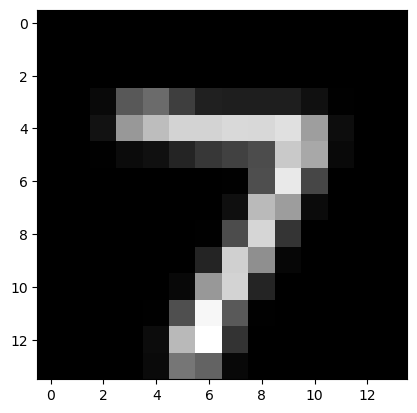

In [21]:
# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

In [23]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()


# Clerical functions
def save_model_weights(model, save_path):
    # Save actual weights and biases, not just their sizes
    weights = (
        (model.fc1.weight, model.fc2.weight, model.fc3.weight),
        (model.fc1.bias, model.fc2.bias, model.fc3.bias)
    )
    torch.save(weights, save_path)

import time

def generate_and_save_clasifiers(N = 1, epochs = 3, start = 0):
    os.makedirs('models', exist_ok=True)
    for i in range(start, N):
        start = time.time()
        seed = i  # Unique seed for each model initialization
        init_type = 'xavier' if i % 2 == 0 else 'he'
        model = MLP(init_type=init_type, seed=seed)
        
        # Train the model for a few epochs 
        train_mlp(model, epochs=epochs) # reduced epochs to 1 for speed

        # Save the weights and biases as tuples of torch.Size
        save_path = f"models/reduced_mlp_weights_{i}.pt"
        save_model_weights(model, save_path)
        del model
        end = time.time()
        print(f"Saved model {i} weights to {save_path} in {(end-start):.3f}s")

# eliminated for speed
#         accuracy = test_mlp(model, test_loader) 
#         print(f"Model {i} Test Accuracy: {accuracy:.2f}%") 


In [31]:
generate_and_save_clasifiers(N = 45, start = 5)

Saved model 5 weights to models/reduced_mlp_weights_5.pt in 11.329s
Saved model 6 weights to models/reduced_mlp_weights_6.pt in 11.597s
Saved model 7 weights to models/reduced_mlp_weights_7.pt in 11.182s
Saved model 8 weights to models/reduced_mlp_weights_8.pt in 11.042s
Saved model 9 weights to models/reduced_mlp_weights_9.pt in 11.085s
Saved model 10 weights to models/reduced_mlp_weights_10.pt in 11.084s
Saved model 11 weights to models/reduced_mlp_weights_11.pt in 11.388s
Saved model 12 weights to models/reduced_mlp_weights_12.pt in 11.068s
Saved model 13 weights to models/reduced_mlp_weights_13.pt in 11.079s
Saved model 14 weights to models/reduced_mlp_weights_14.pt in 11.012s
Saved model 15 weights to models/reduced_mlp_weights_15.pt in 11.149s
Saved model 16 weights to models/reduced_mlp_weights_16.pt in 11.158s
Saved model 17 weights to models/reduced_mlp_weights_17.pt in 10.952s
Saved model 18 weights to models/reduced_mlp_weights_18.pt in 11.018s
Saved model 19 weights to mode

In [25]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """
    Permutes weights and biases of a layer based on the given permutation matrix.
    """
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """
    Applies a list of permutations to a model's layers.
    """
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input weights of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """
    Generates a random permutation matrix.
    """
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    This is the weight matching algorithm (algorithm 2) from Git Re-Basin: Merging Models modulo Permutation Symmetries
    (https://arxiv.org/abs/2209.04836) simplified and demonstrated with these simple MLP Objects...
    
    Optimizes permutations to match Model B to Model A.
    
    Args: 
    rng: random seed/generator
    models a & b: the reference model (a) and model to be rebasined towards it (b)
    max_iter: maximum perm. coord. descent steps the algorithm executes
    init_perm: provide initial permutation mask (optional)

    Returns: 
    perm: the 'best' permutation of model b w.r.t model a 
    new_score: the terminating score of the weight matching algorithm. For hyperparameter tuning. 
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            # Early stopping 
            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

In [27]:
import time

def get_permuted_models_data(ref_point=0, N = 10):
    ref_model = MLP()
    ref_model_path = f"models/reduced_mlp_weights_{ref_point}.pt"
    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times

In [29]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 45)

/var/folders/js/697gbr4j3lzdh9ccy7qxb5ph0000gn/T/ipykernel_70587/467106407.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, biases = torch.load(weight_path)


In [30]:
print(f" First True model test perf.: {test_mlp(org_models[0], test_loader)} \n First permuted model test perf.: {test_mlp(permuted_models[0], test_loader)}")

 First True model test perf.: 93.44 
 First permuted model test perf.: 93.44


In [33]:
def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def plot_tsne(ref_model, org_models, permuted_models):
    """Plot t-SNE of weights and biases from the reference_param, permuted_params_list, and data_points."""
    
    flattened_reference = extract_weights_and_biases(ref_model)
        
    all_params = [flattened_reference]
    
    # Flatten and concatenate all permuted parameters
    for permuted_model in permuted_models:
        flattened_permuted_param = extract_weights_and_biases(permuted_model)
        all_params.append(flattened_permuted_param)
    
    for org_model in org_models:
        org_model_param = extract_weights_and_biases(org_model)
        all_params.append(org_model_param)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=32) # 32
    tsne_results = tsne.fit_transform(np.vstack(all_params))
    
    plt.figure(figsize=(12, 8))
    
    for i, tsne_result in enumerate(tsne_results[1:len(permuted_models)+1], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Permuted Params', color='green')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='green')
    
    # Plot the original data points
    for i, tsne_result in enumerate(tsne_results[len(org_models)+1:], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Original Params', color='blue')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='blue')
                    
    # Plot reference point
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='Reference (ref_point)', color='red', marker='X')
    
    # Add titles and labels
    plt.title("t-SNE visualization of weights and biases for 1 reference parameter, permuted params, and data points")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
    # Show plot
    plt.show("tsne_plot.png")
    

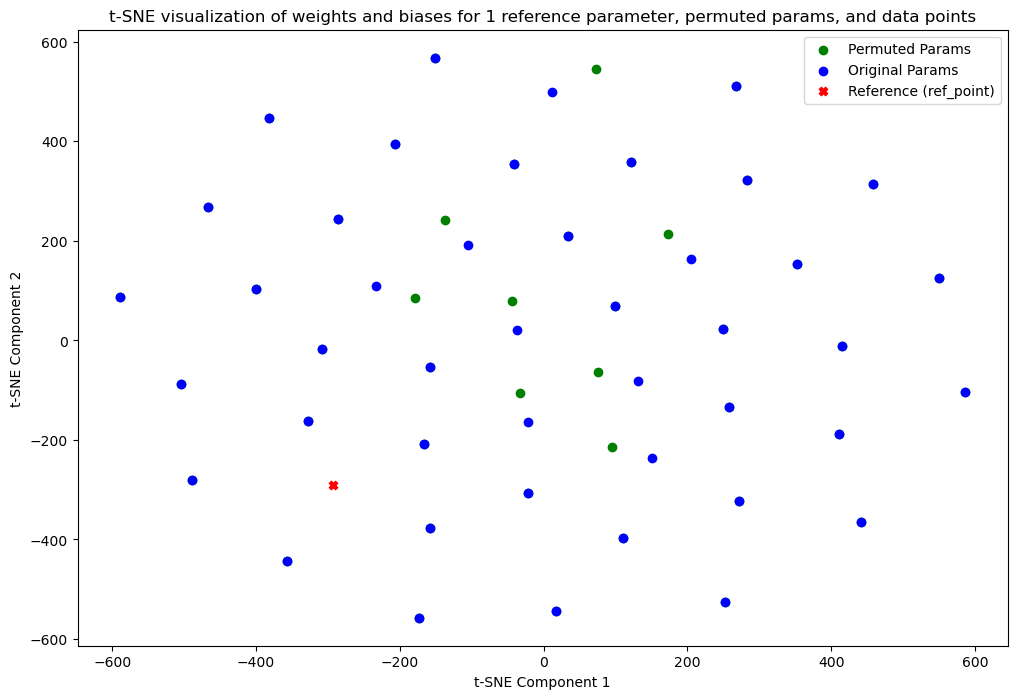

In [35]:
plot_tsne(org_models[0], org_models, permuted_models)

# Normalize scale invariance

In [38]:
import copy
from typing import List

def rescale_mlp(mlp: MLP) -> MLP:
    """
    Returns a new MLP whose parameters have been divided by the largest
    positive parameter in the original model.
    """
    # 1) Find the maximum positive parameter in this network
    max_val = 0.0
    for param in mlp.parameters():
        p_max = float(param.data.max())
        if p_max > max_val:
            max_val = p_max

    # If there are no positives, we’ll just return an identical copy
    if max_val <= 0:
        return copy.deepcopy(mlp)

    # 2) Deep‐copy the model so we don’t clobber the original
    mlp_scaled = copy.deepcopy(mlp)

    # 3) Divide every weight & bias in-place by max_val
    for param in mlp_scaled.parameters():
        param.data.div_(max_val)

    return mlp_scaled

def rescale_mlps(mlps: List[MLP]) -> List[MLP]:
    """
    Processes a list of MLPs, returning a new list where each MLP’s
    parameters have been rescaled so that its largest positive parameter
    is 1.0.
    """
    return [rescale_mlp(m) for m in mlps]


Some sanity-checks: 
* Do the rescaled networks have maximum parameter value of 1? (Yes)
* Do the rescaled, rebasin permuted, and originally trained models all have the same test performance on data? (Yes)
* tSNE of permuted vs rescaled, they should be similar. (Yes)

In [42]:
models = permuted_models # [MLP(init_type='xavier', seed=s) for s in range(5)]
models_rescaled = rescale_mlps(models)

# Verify
print(max(p.max().item() for p in models_rescaled[0].parameters()))  # -> 1.0


1.0


In [46]:
model = models[0]
test_mlp(model, test_loader)

93.44

In [48]:
model = permuted_models[0]
test_mlp(model, test_loader)

93.44

In [50]:
model = org_models[0]
test_mlp(model, test_loader)

93.44

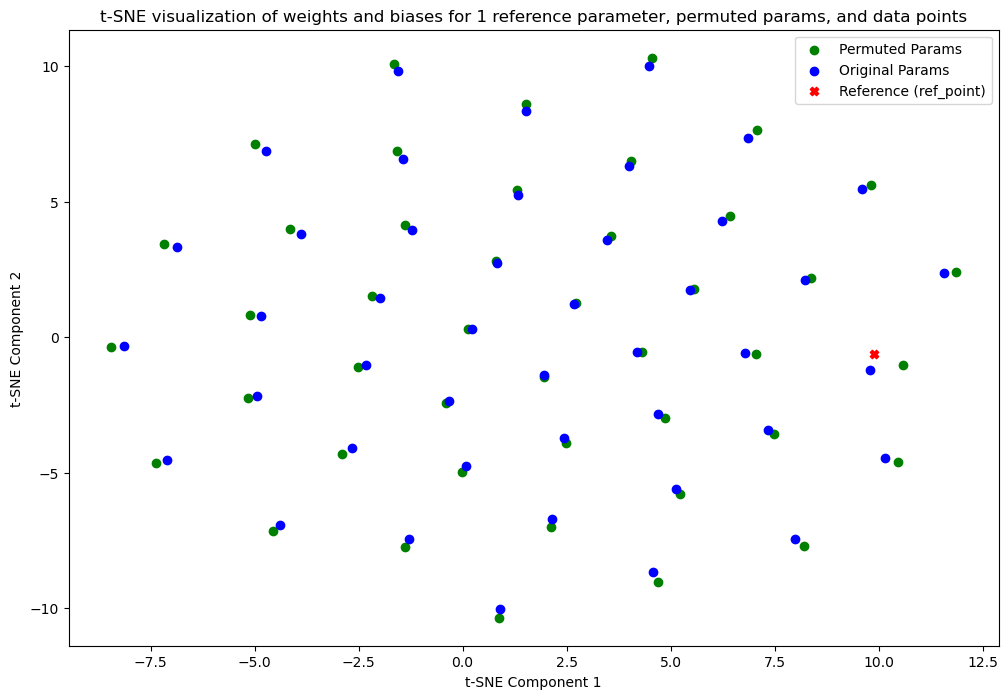

In [59]:
plot_tsne(org_models[0], permuted_models, models_rescaled)
# excuse the incorrect title/labels in this case